# Multi-Label Classification with an Irrigation Machine

Multi-label classification problems differ from multi-class problems in that each observation can be labeled with zero or more classes. So classes/labels are not mutually exclusive, you could water all, none or any combination of farm parcels based on the inputs.

To account for this behavior what we do is have an output layer with as many neurons as classes but, unlike in multi-class problems, each output neuron has a sigmoid activation function. This makes each neuron in the output layer able to output a number between 0 and 1 independently.

Here, we have a dataset of a farm field. In it is an array of 20 sensors distributed along 3 crop fields. These sensors measure, among other things, the humidity of the soil, radiation of the sun, etc. Our task is to use the combination of measurements from these sensors to decide which parcels to water, given each parcel has different environmental requirements.

Each sensor measures an integer value between 0 and 13 volts. Parcels can be represented as one-hot encoded vectors of length 3, where each index is one of the parcels. Parcels can be watered simultaneously.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Import the sequential model and dense layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

2024-07-28 23:17:06.714453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# read the data
irrigation_machine = pd.read_csv('data/irrigation_machine.csv')
irrigation_machine.head()

,Unnamed: 0,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
0,0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,...,8.0,1.0,0.0,2.0,1.0,9.0,2.0,0,1,0
1,1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,...,4.0,5.0,5.0,2.0,2.0,2.0,7.0,0,0,0
2,2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,...,3.0,3.0,1.0,0.0,3.0,1.0,0.0,1,1,0
3,3,2.0,2.0,4.0,3.0,5.0,0.0,3.0,2.0,2.0,...,4.0,1.0,1.0,4.0,1.0,3.0,2.0,0,0,0
4,4,4.0,3.0,3.0,2.0,5.0,1.0,3.0,1.0,1.0,...,1.0,3.0,2.0,2.0,1.0,1.0,0.0,1,1,0


In [4]:
irrigation_machine.describe()

,Unnamed: 0,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,999.500000,1.437000,1.659000,2.654500,2.674500,2.887500,1.411000,3.315500,4.201500,1.214000,...,2.731500,3.416000,1.206500,2.325000,1.729500,2.27450,1.813500,0.63550,0.730500,0.212000
std,577.494589,1.321327,1.338512,1.699286,1.855875,1.816451,1.339394,2.206444,2.280241,1.386782,...,1.774537,1.960578,1.258034,1.715181,1.561265,1.67169,1.469285,0.48141,0.443811,0.408827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,499.750000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,2.000000,3.000000,0.000000,...,1.000000,2.000000,0.000000,1.000000,0.000000,1.00000,1.000000,0.00000,0.000000,0.000000
50%,999.500000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,3.000000,4.000000,1.000000,...,2.000000,3.000000,1.000000,2.000000,1.000000,2.00000,2.000000,1.00000,1.000000,0.000000
75%,1499.250000,2.000000,2.000000,4.000000,4.000000,4.000000,2.000000,5.000000,6.000000,2.000000,...,4.000000,5.000000,2.000000,3.000000,3.000000,3.00000,3.000000,1.00000,1.000000,0.000000
max,1999.000000,8.000000,9.000000,10.000000,11.000000,12.000000,7.000000,13.000000,12.000000,8.000000,...,11.000000,11.000000,6.000000,10.000000,11.000000,10.00000,7.000000,1.00000,1.000000,1.000000


In [5]:
irrigation_machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2000 non-null   int64  
 1   sensor_0    2000 non-null   float64
 2   sensor_1    2000 non-null   float64
 3   sensor_2    2000 non-null   float64
 4   sensor_3    2000 non-null   float64
 5   sensor_4    2000 non-null   float64
 6   sensor_5    2000 non-null   float64
 7   sensor_6    2000 non-null   float64
 8   sensor_7    2000 non-null   float64
 9   sensor_8    2000 non-null   float64
 10  sensor_9    2000 non-null   float64
 11  sensor_10   2000 non-null   float64
 12  sensor_11   2000 non-null   float64
 13  sensor_12   2000 non-null   float64
 14  sensor_13   2000 non-null   float64
 15  sensor_14   2000 non-null   float64
 16  sensor_15   2000 non-null   float64
 17  sensor_16   2000 non-null   float64
 18  sensor_17   2000 non-null   float64
 19  sensor_18   2000 non-null  

According to the dataset, there is a total of 23 columns: 20 columns for the sensors and 3 columns representing each farm parcel. 

There are no null values.

Next, we will train the neural network that just needs one input and 2 hidden neurons. We'll use sigmoid outputs as we turn our focus away from the sum of probabilities. Now, we want each output neuron to be able to take a value between 0 and 1. The sigmoid activation constrains our neuron output in the range of 0-1.

For the loss function, we'll use binary cross-entropy when we compile our model. We can look at it as if we were planning several beinary classification problems: for each output we are deciding whether or not its corresponding label is present given the current input.

In [6]:
# Instantiate a Sequential model
model = Sequential()

model.add(Input(shape=(20,)))

# Add a hidden layer of 64 neurons and a 20 neuron's input
model.add(Dense(64, activation='relu'))

# Add an output layer of 3 neurons with sigmoid activation
model.add(Dense(3, activation='sigmoid'))

# Compile your model with binary crossentropy loss
model.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,539 (6.01 KB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
sensors = irrigation_machine.drop(columns=['Unnamed: 0','parcel_0', 'parcel_1', 'parcel_2'], axis=1).values
parcels = irrigation_machine[['parcel_0', 'parcel_1', 'parcel_2']].values

X_train, X_test, y_train, y_test = train_test_split(sensors, parcels, test_size=0.2, random_state=42)

# train for 100 epocs using validation split of 0.2
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

# predict on testing set
preds = model.predict(X_test)
preds_rounded = np.round(preds)

# print rounded preds
print('Rounded Predictions: \n', preds_rounded)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6291 - loss: 0.1328 - val_accuracy: 0.6344 - val_loss: 0.1416
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6381 - loss: 0.1453 - val_accuracy: 0.6281 - val_loss: 0.1464
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6264 - loss: 0.1326 - val_accuracy: 0.5906 - val_loss: 0.1486
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6275 - loss: 0.1288 - val_accuracy: 0.5781 - val_loss: 0.1592
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5973 - loss: 0.1321 - val_accuracy: 0.6000 - val_loss: 0.1558
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5899 - loss: 0.1264 - val_accuracy: 0.6406 - val_loss: 0.1559
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6153 - loss: 0.1181 - val_accuracy: 0.6469 - val_loss: 0.1611
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6057 - loss: 0.1343 - val_accuracy: 0.6156 - v

In [12]:
# evaluate model's accuracy on the test data
accuracy = model.evaluate(X_test, y_test)[1]

print('Accuracy:', accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.5892 - loss: 0.3534
Accuracy: 0.5950000286102295


## History Callback

The history callback is returned by default every time we train a model with the `.fit()` method. We can access these metrics via the history dictionary parameter inside the returned `h_callback` object with the corresponding keys.

Below we'll store the model's `historycallback` and use the `validation_data` parameter as it trains.

In [21]:
# Instantiate a Sequential model
model = Sequential()

model.add(Input(shape=(20,)))

# Add a hidden layer of 64 neurons and a 20 neuron's input
model.add(Dense(64, activation='relu'))

# Add an output layer of 3 neurons with sigmoid activation
model.add(Dense(3, activation='sigmoid'))

# Compile your model with binary crossentropy loss
model.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,539 (6.01 KB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# train your model and save its history
h_callback = model.fit(X_train,
                       y_train,
                       epochs = 50,
                       validation_data=(X_test, y_test))
                       

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4560 - loss: 1.0882 - val_accuracy: 0.5925 - val_loss: 0.5463
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6001 - loss: 0.5059 - val_accuracy: 0.6600 - val_loss: 0.3906
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 0.4034 - val_accuracy: 0.7025 - val_loss: 0.3279
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6715 - loss: 0.3366 - val_accuracy: 0.6150 - val_loss: 0.2987
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6459 - loss: 0.3183 - val_accuracy: 0.6500 - val_loss: 0.2778
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6426 - loss: 0.2815 - val_accuracy: 0.6725 - val_loss: 0.2712
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6773 - loss: 0.2626 - val_accuracy: 0.6800 - val_loss: 0.2593
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6158 - loss: 0.2654 - val_accuracy: 0.6100 - val_loss:

Lastly, we will plot the results stored in history with `plot_accuracy()` and `plot_loss()`, two simple custom matplotlib functions.

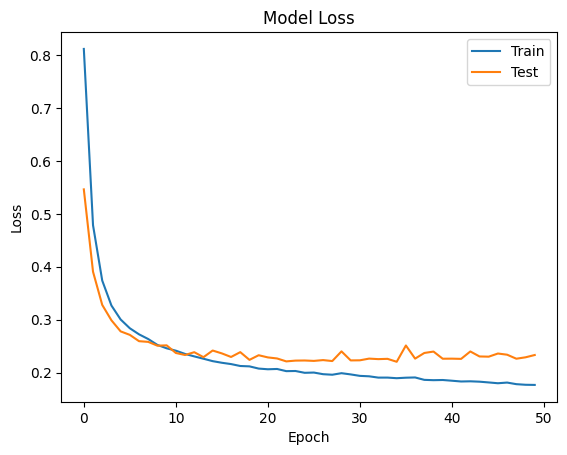

Loss: [0.8118833303451538, 0.47859010100364685, 0.3738916516304016, 0.3266971707344055, 0.30029621720314026, 0.28368887305259705, 0.2722112536430359, 0.26333022117614746, 0.2521767318248749, 0.2458130419254303, 0.2413133829832077, 0.2351837307214737, 0.2305198311805725, 0.2260885387659073, 0.22152739763259888, 0.2184583693742752, 0.2159782201051712, 0.21234995126724243, 0.21165117621421814, 0.2074604630470276, 0.20617112517356873, 0.20672675967216492, 0.20261609554290771, 0.2028886079788208, 0.1994713991880417, 0.19994178414344788, 0.19685788452625275, 0.1958424597978592, 0.1987481564283371, 0.19643570482730865, 0.193683922290802, 0.19285835325717926, 0.19039766490459442, 0.19042687118053436, 0.1892770230770111, 0.19022607803344727, 0.19068072736263275, 0.18614020943641663, 0.1855364739894867, 0.18587082624435425, 0.18450956046581268, 0.1830577403306961, 0.18339845538139343, 0.18269367516040802, 0.18125322461128235, 0.17974239587783813, 0.181015744805336, 0.1780007779598236, 0.17685046

In [23]:
# helper function to plot train vs test loss
def plot_lost(loss, val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

plot_lost(h_callback.history["loss"], h_callback.history["val_loss"])

print(f'Loss: {h_callback.history["loss"]}')
print()
print(f'Val_loss: {h_callback.history["val_loss"]}')

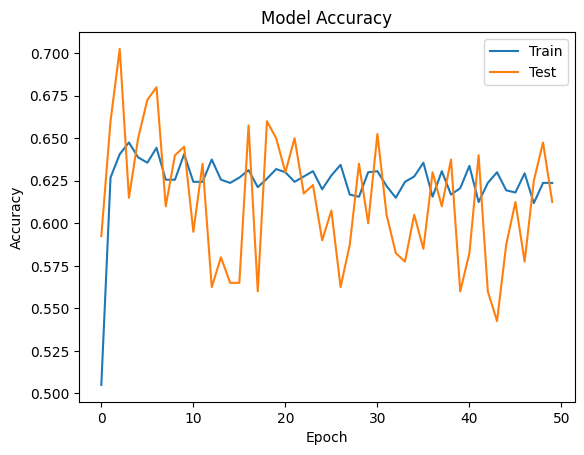

Accuracy: [0.5049999952316284, 0.6268749833106995, 0.640625, 0.6474999785423279, 0.6387500166893005, 0.6356250047683716, 0.6443750262260437, 0.6256250143051147, 0.6256250143051147, 0.640625, 0.6243749856948853, 0.6243749856948853, 0.637499988079071, 0.6256250143051147, 0.6237499713897705, 0.6268749833106995, 0.6312500238418579, 0.6212499737739563, 0.6262500286102295, 0.6318749785423279, 0.6299999952316284, 0.6243749856948853, 0.6274999976158142, 0.6306250095367432, 0.6200000047683716, 0.628125011920929, 0.6343749761581421, 0.6168749928474426, 0.6156250238418579, 0.6299999952316284, 0.6306250095367432, 0.621874988079071, 0.6150000095367432, 0.6243749856948853, 0.6274999976158142, 0.6356250047683716, 0.6156250238418579, 0.6306250095367432, 0.6168749928474426, 0.6206250190734863, 0.6337500214576721, 0.612500011920929, 0.6237499713897705, 0.6299999952316284, 0.6193749904632568, 0.6181250214576721, 0.6293749809265137, 0.6118749976158142, 0.6237499713897705, 0.6237499713897705]

Val_accuracy

In [27]:
# helper function to plot train vs test loss
def plot_accuracy(acc, val_acc):
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

plot_accuracy(h_callback.history["accuracy"], h_callback.history["val_accuracy"])

print(f'Accuracy: {h_callback.history["accuracy"]}')
print()
print(f'Val_accuracy: {h_callback.history["val_accuracy"]}')

These graphs help us detect overfitting and to know if our neural network would benefit from more training data.

## Early Stopping Callback

The early stopping callback is useful since it allows us to stop the model training if it no longer improves after a given number of epochs.

Below we'll set the epochs to 1000 define the cal;back with a `patience` of 10 epochs.

In [29]:
# Instantiate a Sequential model
model = Sequential()

model.add(Input(shape=(20,)))

# Add a hidden layer of 64 neurons and a 20 neuron's input
model.add(Dense(64, activation='relu'))

# Add an output layer of 3 neurons with sigmoid activation
model.add(Dense(3, activation='sigmoid'))

# Compile your model with binary crossentropy loss
model.compile(optimizer='adam',
           loss = 'binary_crossentropy',
           metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,539 (6.01 KB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Import the early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=10)

# Train  model using the early stopping callback
model.fit(X_train, y_train, 
           epochs=1000, validation_data=(X_test, y_test),
           callbacks= [monitor_val_acc])

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6080 - loss: 0.2049 - val_accuracy: 0.6025 - val_loss: 0.2259
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6069 - loss: 0.2107 - val_accuracy: 0.6025 - val_loss: 0.2250
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5653 - loss: 0.2083 - val_accuracy: 0.6025 - val_loss: 0.2376
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5847 - loss: 0.2118 - val_accuracy: 0.5825 - val_loss: 0.2256
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5782 - loss: 0.1995 - val_accuracy: 0.5800 - val_loss: 0.2214
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5925 - loss: 0.2006 - val_accuracy: 0.5950 - val_loss: 0.2201
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6065 - loss: 0.1956 - val_accuracy: 0.6150 - val_loss: 0.2240
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5980 - loss: 0.2099 - val_accuracy: 0.